In [2]:
import math
import torch
from inspect import isfunction
from functools import partial
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler

In [4]:

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def extract(a, t, x_shape=(1,1,1)):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

# beta_schedule function
def _warmup_beta(linear_start, linear_end, n_timestep, warmup_frac):
    betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    warmup_time = int(n_timestep * warmup_frac)
    betas[:warmup_time] = np.linspace(
        linear_start, linear_end, warmup_time, dtype=np.float64)
    return betas

def make_beta_schedule(schedule, n_timestep, linear_start=1e-6, linear_end=1e-2, cosine_s=8e-3):
    if schedule == 'quad':
        betas = np.linspace(linear_start ** 0.5, linear_end ** 0.5,
                            n_timestep, dtype=np.float64) ** 2
    elif schedule == 'linear':
        betas = np.linspace(linear_start, linear_end,
                            n_timestep, dtype=np.float64)
    elif schedule == 'warmup10':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.1)
    elif schedule == 'warmup50':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.5)
    elif schedule == 'const':
        betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    elif schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / np.linspace(n_timestep,
                                 1, n_timestep, dtype=np.float64)
    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) /
            n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * math.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = betas.clamp(max=0.999)
    else:
        raise NotImplementedError(schedule)
    return betas


def q_sample( y_0, sample_gammas, noise=None):
    noise = default(noise, lambda: torch.randn_like(y_0))
    return (
        sample_gammas.sqrt() * y_0 +
        (1 - sample_gammas).sqrt() * noise
    )

In [5]:
def forward(y_0,gammas,num_timesteps = 2000,y_cond=None, mask=None, noise=None):
    # sampling from p(gammas)
    b, *_ = y_0.shape

    t = torch.randint(1, num_timesteps, (b,)).long()
    gamma_t1 = extract(gammas, t-1, x_shape=(1,))
    sqrt_gamma_t2 = extract(gammas, t, x_shape=(1,))
    sample_gammas = (sqrt_gamma_t2-gamma_t1) * torch.rand((b,)) + gamma_t1
    sample_gammas = sample_gammas.view(b, -1)

    noise = default(noise, lambda: torch.randn_like(y_0))
    y_noisy =q_sample(
        y_0=y_0, sample_gammas=sample_gammas.view(-1, 1, 1), noise=noise)
    return y_noisy

In [6]:
num_timesteps = 2000
schedule='linear'
betas = make_beta_schedule(schedule=schedule,n_timestep=num_timesteps,linear_end=0.01,linear_start=1e-6,cosine_s=0.008)
alphas = 1. - betas
gammas = np.cumprod(alphas, axis=0)

noisy= forward(val[0,:,0],gammas)
plt.plot(noisy)


NameError: name 'val' is not defined

In [3]:
DATA_DIR = r"..\data\processed\BP_npy\0209_256_2\p00\validate.npy"
val = np.load(DATA_DIR)
val.shape

(47374, 256, 2)

In [5]:
from scipy import signal
import pandas as pd

In [7]:
a = []
for i in tqdm(range(len(val))):
    s1 = pd.Series(val[i][:,0])
    s2 = pd.Series(val[i][:,1])
    r = s1.corr(s2)
    a.append(r)

100%|██████████| 47374/47374 [00:04<00:00, 11752.92it/s]


0.2549678200095287 11


(2, (256, 2))

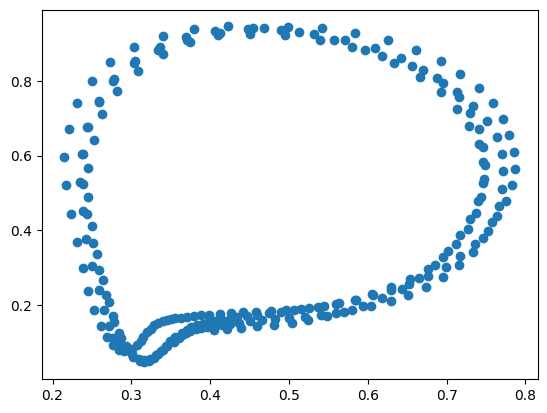

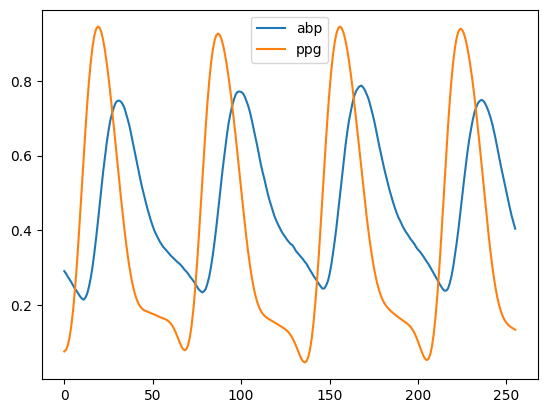

In [8]:
i = np.random.randint(len(val))
i =2
t = val[i]
correlation = signal.correlate(t[:,0], t[:,1], mode='full')[t[:,0].size:t[:,0].size+200]
lags = signal.correlation_lags(t[:,0].size, t[:,1].size, mode="full")[t[:,0].size:t[:,0].size+200]
lag = lags[np.argmax(correlation)]
print(a[i],lag)
plt.scatter(t[:,0],t[:,1],label='abp')
plt.figure()
plt.plot(t[:,0],label='abp')
plt.plot(t[:,1],label='ppg')
plt.legend()
i,t.shape

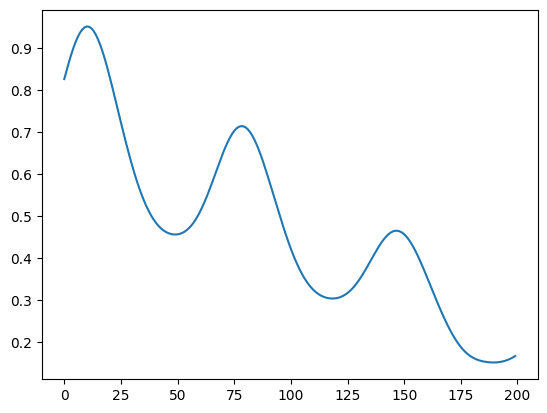

In [25]:
pcorr =  correlation / (np.linalg.norm(t[:,0], ord=2) *  np.linalg.norm(t[:,1], ord=2))
plt.plot(pcorr)

array([53.78651617, 55.08641788, 56.33175505, 57.50016342, 58.56989765,
       59.5204882 , 60.333247  , 60.99179445, 61.48294037, 61.79682671,
       61.92715062, 61.87138287, 61.63040121, 61.20897537, 60.61513541,
       59.86014513, 58.95767881, 57.92342643, 56.774739  , 55.52991606,
       54.20757887, 52.82644338, 51.40451517, 49.95921845, 48.50640079,
       47.06062868, 45.63493813, 44.24088456, 42.88815765, 41.58495079,
       40.33830291, 39.15389116, 38.03624041, 36.98891247, 36.01459696,
       35.11531634, 34.29195455, 33.54468066, 32.87309474, 32.27567367,
       31.75023591, 31.293741  , 30.902933  , 30.57397665, 30.30305922,
       30.08652529, 29.92130105, 29.80515645, 29.73669764, 29.71570478,
       29.74301994, 29.8206181 , 29.95122316, 30.13833754, 30.38585969,
       30.69751752, 31.07678549, 31.52617047, 32.04738467, 32.6407183 ,
       33.30489041, 34.03681303, 34.831628  , 35.68259125, 36.58108469,
       37.51661069, 38.47712985, 39.44910629, 40.41775397, 41.36

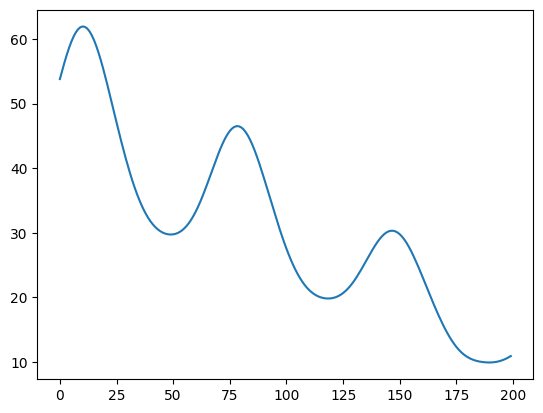

In [20]:
plt.plot(correlation)
correlation

In [21]:
dot = np.dot(t[:,0], t[:,1])
dot

52.45412038734678

In [14]:
import pandas as pd
def remove_lowcorr(sig):
    a = []
    for i in tqdm(range(len(sig))):
        s1 = pd.Series(sig[i][:,0])
        s2 = pd.Series(sig[i][:,1])
        r = s1.corr(s2)
        a.append(r)
    high = np.where(np.array(a) > 0.8)[0]
    print(len(high))
    return sig[high],high

In [ ]:
DATA_DIR = r"..\data\processed\BP_npy\0125_align_norm3_256\p00"
SAVE_DIR = r"..\data\processed\BP_npy\0123_08_align_norm3_256\p00"
os.makedirs(SAVE_DIR,exist_ok=True)
phase = ["train","validate","test"]
for i in phase:
    train = np.load(DATA_DIR+f"\\{i}.npy")
    scale = np.load(DATA_DIR+f"\\scale_{i}.npy")
    train,high = remove_lowcorr(train)
    np.save(SAVE_DIR+f"\\{i}.npy",train)
    np.save(SAVE_DIR+f"\\scale_{i}.npy",scale[high])

  9%|▊         | 35013/402681 [00:03<00:32, 11187.19it/s]


KeyboardInterrupt: 

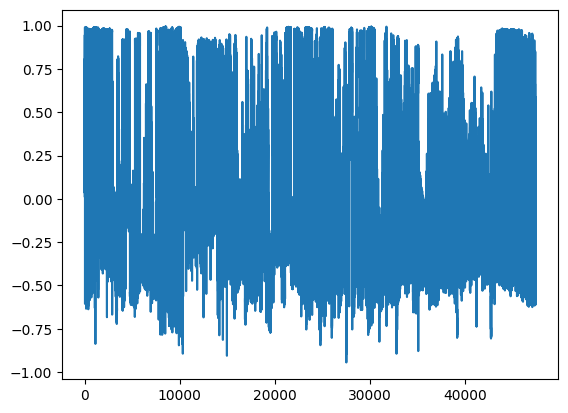

In [ ]:
plt.plot(a)

In [ ]:
np.array(a).mean()

0.24388757954324317

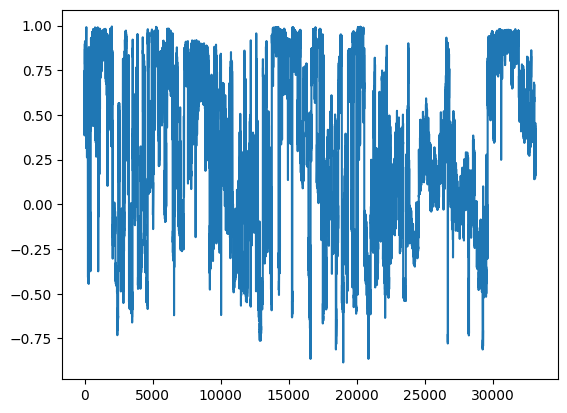

In [ ]:
plt.plot(a)

In [ ]:
len(np.where(np.array(a)<0.3)[0])

13468

In [16]:
b = np.where(np.array(a)<0.3)[0]

In [17]:
b[0]

2

In [ ]:
np.array(a).mean()

0.32034404485428863

In [ ]:
a

NameError: name 'a' is not defined